In this notebook we use the same image data set as in the svm notebook. This is because neural network is known for good at classifying image data.

As Neural Networks usually have millions of parameters and are very complex models, the interpretability is worse than many other machin learning models. Overfitting is therefore a problem for neural networks, and it can be alleviated by using regularization techniques such as dropouts.

On datasets (especially tabular datasets) where random forest and boosting methods can get relatively good performances, using Neural Network may not be the best choice. When dealing with complex data such as images, videos, sounds and sequences, neural network is usually the go-to method.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_lfw_people
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from time import time

In [ ]:
face_df = fetch_lfw_people(min_faces_per_person=60)
print(face_df.target_names)
print(face_df.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Our dataset consists of 62*47 images and has people's names as labels. Our objective is to correctly predict who the person is given an image.

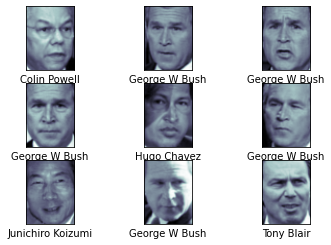

In [ ]:
fig, ax = plt.subplots(3, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_df.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=face_df.target_names[face_df.target[i]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(face_df.data, face_df.target, test_size=0.3, random_state=42)
target_names = face_df.target_names

#### Multi Layer Perceptron

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
tf.random.set_seed(46)

In [ ]:
# noramlize the data points
max_ = X_train.max(axis=0)
min_ = X_train.min(axis=0)

X_train_norm = (X_train - min_) / (max_ - min_)
X_test_norm = (X_test - min_) / (max_ - min_)

In [ ]:
X_train_norm.shape

(943, 2914)

In [ ]:
X_test_norm.shape

(405, 2914)

In [ ]:
np.prod(X_train_norm.shape[1:])

2914

In [ ]:
dim_data = np.prod(X_train_norm.shape[1:])

train_data = X_train_norm.reshape(X_train_norm.shape[0], dim_data)

test_data = X_test_norm.reshape(X_test_norm.shape[0], dim_data)

In [ ]:
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(dim_data,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(target_names), activation='softmax'))


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_crossentropy','accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

Best Validation Loss: 0.6926
Best Validation Accuracy: 0.8049


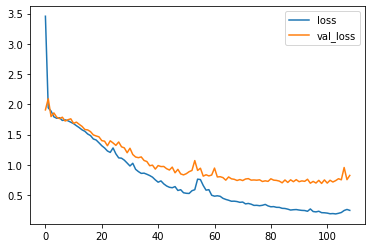

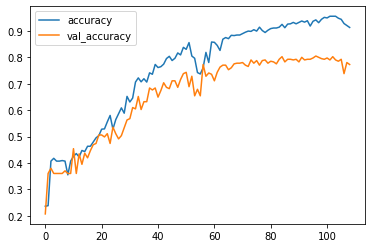

In [ ]:
history = model.fit(
    train_data, train_labels_one_hot,
    validation_data=(test_data, test_labels_one_hot),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)

# plot history
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

#### Multi Layer Perceptron - Add Regularization

Adding dropout layers is one way to add regularization for neural networks. This may help reduce overfitting if overfitting is present.

Best Validation Loss: 0.6554
Best Validation Accuracy: 0.8198


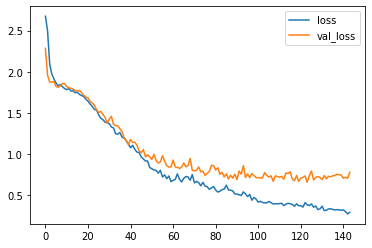

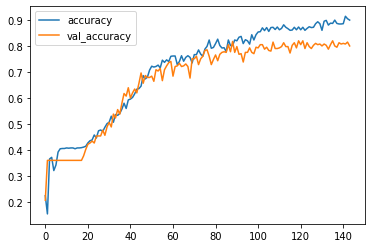

In [ ]:
from tensorflow.keras.layers import Dropout
model_reg = keras.Sequential()
model_reg.add(layers.Dense(512, activation='relu', input_shape=(dim_data,)))
model_reg.add(Dropout(0.3))
model_reg.add(layers.Dense(512, activation='relu'))
model_reg.add(Dropout(0.3))
model_reg.add(layers.Dense(256, activation='relu'))
model_reg.add(Dropout(0.3))
model_reg.add(layers.Dense(len(target_names), activation='softmax'))


model_reg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_crossentropy','accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model_reg.fit(
    train_data, train_labels_one_hot,
    validation_data=(test_data, test_labels_one_hot),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)

# plot history
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

Adding regularization reduces overfitting, but do not significantly improves the model performance.

#### Convolutional Neural Network

Convolutional networks use convolutional layers to extract features from images. Usually it is from low-level features (edges, etc.) to high level features (features that can help classification).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(face_df.data, face_df.target, test_size=0.3, random_state=42)
X_train = X_train.reshape((len(X_train),62,47,1))
X_test = X_test.reshape((len(X_test),62,47,1))
print(X_train.shape)

(943, 62, 47, 1)


In [ ]:
print(face_df.images.shape)

(1348, 62, 47)


In [ ]:
input_shape = (62, 47, 1)
model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(len(target_names), activation="softmax"),
    ]
)

model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dropout_9 (Dropout)         (None, 8960)             

Best Validation Loss: 0.6737
Best Validation Accuracy: 0.8469


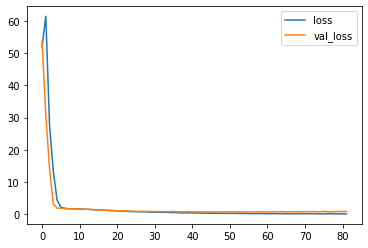

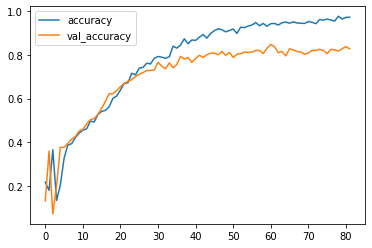

In [ ]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_crossentropy','accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model_cnn.fit(
    X_train, train_labels_one_hot,
    validation_data=(X_test, test_labels_one_hot),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)

# plot history
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

#### Confusion Matrix for CNN

In [ ]:
# we define a new function to give us evaluation metrics and visualizations (with codes in Logistic_Regression.ipynb)
def plot_confusion(model, X_test, y_test):
  # predicted values on the testing data
  y_pred = model.predict(X_test)
  y_pred = [np.argmax(pred) for pred in list(y_pred)]
  print(classification_report(y_test, y_pred))

  # print accuracy
  print('Accuracy: ', sum(y_pred == y_test)/len(y_test))

  # The confusion matrix
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  # Convert confusion matrix into dataframe
  matrix_df = pd.DataFrame(confusion_matrix)


  plt.figure(figsize=(8, 8))
  ax = plt.axes()
  sns.set(font_scale=1.3)

  sns.heatmap(matrix_df,
              annot = True, 
              fmt = "g",
              ax = ax, 
              cmap = "magma", 
              cbar = False)

  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Label", fontsize=15)
  ax.set_xticklabels(face_df.target_names, rotation = 45)
  ax.set_ylabel("True Label", fontsize=15)
  ax.set_yticklabels(face_df.target_names, rotation=0)
  plt.show()

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.91      0.92      0.91        84
           2       0.85      0.78      0.81        36
           3       0.84      0.91      0.87       146
           4       0.71      0.61      0.65        28
           5       0.79      0.56      0.65        27
           6       0.94      1.00      0.97        16
           7       0.79      0.75      0.77        51

    accuracy                           0.84       405
   macro avg       0.82      0.80      0.81       405
weighted avg       0.83      0.84      0.83       405

Accuracy:  0.837037037037037


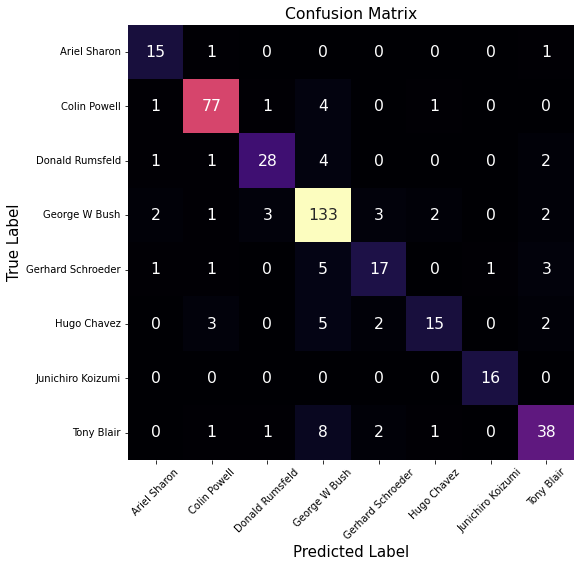

In [ ]:
plot_confusion(model_cnn, X_test, y_test)

CNN achieves better performance than MLP. Tuning Parameters can potentially get us better results!